In [10]:
import pandas as pd
import time
import spacy
import numpy as np
from datetime import datetime, timezone
import pytz  
import tzlocal
from dateutil import tz
import re
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from collections import defaultdict
from backports.zoneinfo import ZoneInfo
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from os import path

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# data visualization
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [11]:
df = pd.read_csv("base2_anotada.csv", encoding='UTF-8')

In [12]:
df.shape

(9605, 9)

In [13]:
df.head()

Unnamed: 0.1  Unnamed: 0      Tweet_ID Sentiment  \
0             0      252278  1.503750e+18    neutro   
1             1      157301  1.539940e+18  negativo   
2             2      203491  1.522780e+18    neutro   
3             3      263418  1.496420e+18    neutro   
4             4      140421  1.545780e+18  positivo   

                                          Tweet_Text  \
0  minha gente, em minha última live abri o coraç...   
1  👇👇👇👇👇👇👇👇 "a suprema corte brasileira planeja c...   
2  guerra cultural e as eleições de outubro https...   
3  eleições 2022.  federações, uma aposta incerta...   
4  um assunto nacional do brasil, não tem que se ...   

                  Created_at Tweet_Geo                         User_Name  \
0  2022-03-15 14:52:24+00:00       NaN                  Emanuel Pinheiro   
1  2022-06-23 12:02:56+00:00       NaN                       Maria Paula   
2  2022-05-07 03:10:38+00:00       NaN                 🎗Dilma Resistente   
3  2022-02-23 09:37:08+00:00       NaN                        Pedro Luiz   
4  2022-07-09 14:36:02+00:00       NaN  🇧🇷 Robson Barros 🇧🇷 ( 3.42k ) 🇧🇷   

            User_Location  
0              Cuiabá, MT  
1                 Brasil   
2                     NaN  
3                  OLINDA  
4  Teresina, Piaui Brasil

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9605 entries, 0 to 9604
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.1   9605 non-null   int64  
 1   Unnamed: 0     9605 non-null   int64  
 2   Tweet_ID       9605 non-null   float64
 3   Sentiment      9605 non-null   object 
 4   Tweet_Text     9605 non-null   object 
 5   Created_at     9605 non-null   object 
 6   Tweet_Geo      259 non-null    object 
 7   User_Name      9600 non-null   object 
 8   User_Location  6667 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 675.5+ KB


## Pré-processamento

In [15]:
nlp = spacy.load('pt_core_news_lg')
def preprocess(df):
    stop_words = stopwords.words('portuguese')
    new_stopwords= ['q','pro', 'pra','tar','ter', 'pq', 'aí', 'então', 'porque', 'ir', 'vc', 'tá', 'd', 'sobre', 
                    'prá', 'todo', 'vir' ]
    stop_words.extend(new_stopwords)
    st = RSLPStemmer()
    
    #df['Tweet_Text'] = str(df['Tweet_Text'])
    
    df['Tweet_Text'].dropna(inplace=True)

    #Remove nome de usuários (está diminuindo a precisão)
    df['Tweet_Text'] = [re.sub('@[^\s]+','', entry) for entry in df['Tweet_Text']]

    # Remove @RT de retweets
    df['Tweet_Text'] = [re.sub(r'^RT[\s]+', '', entry) for entry in df['Tweet_Text']]

    # Remove hiperlinks
    df['Tweet_Text'] = [re.sub(r'https?:\/\/.*[\r\n]*', '', entry) for entry in df['Tweet_Text']]
    
    #Lemetizacao
    df["Tweet_Text"] = df['Tweet_Text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
    
    #stemming
    #df["Tweet_Text"] = df['Tweet_Text'].apply(lambda x: " ".join([st.stem(word) for word in df['Tweet_Text']]))
    
    # Padroniza todo o texto em caixa baixa (letras minúsculas)
    df['Tweet_Text'] = [entry.lower() for entry in df['Tweet_Text']]
    
    #Remover stopwords
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and word.isalpha()]))
    
    
    #Tokenização: Cada tweet é dividido em um array de palavras
    df['Tweet_Text']= [word_tokenize(entry) for entry in df['Tweet_Text']]
    
    #transformar tweet text em array de strings
    df['Text_Final']= [str(item) for item in df['Tweet_Text']]

    #Remove Z format
    date_column = []
    for datez in df['Created_at']:
        datez= (datez.split("+", 1))[0]
        date_column.append(datez)
    df['Created_at'] = date_column
    
    #convert timezone

    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz("America/Sao_Paulo")
    local = []
    for date in df['Created_at']:
        date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
        date = date.replace(tzinfo=from_zone)
        # Convert time zone
        date = date.astimezone(to_zone)
        local.append(date)

    df['Created_at'] = local
    
    #separate column date to date and time
    df['Date_Created'] = pd.to_datetime(df['Created_at']).dt.date
    df['Time_Created'] = pd.to_datetime(df['Created_at']).dt.time
    
 

In [16]:
preprocess(df)

In [17]:
df.head()

Unnamed: 0.1  Unnamed: 0      Tweet_ID Sentiment  \
0             0      252278  1.503750e+18    neutro   
1             1      157301  1.539940e+18  negativo   
2             2      203491  1.522780e+18    neutro   
3             3      263418  1.496420e+18    neutro   
4             4      140421  1.545780e+18  positivo   

                                          Tweet_Text  \
0  [gente, último, live, abrir, coração, falar, e...   
1  [supremo, corte, brasileiro, planejar, coopera...   
2               [guerra, cultural, eleição, outubro]   
3              [eleição, federação, aposta, incerto]   
4  [assunto, nacional, brasil, discutir, paris, n...   

                 Created_at Tweet_Geo                         User_Name  \
0 2022-03-15 11:52:24-03:00       NaN                  Emanuel Pinheiro   
1 2022-06-23 09:02:56-03:00       NaN                       Maria Paula   
2 2022-05-07 00:10:38-03:00       NaN                 🎗Dilma Resistente   
3 2022-02-23 06:37:08-03:00       NaN                        Pedro Luiz   
4 2022-07-09 11:36:02-03:00       NaN  🇧🇷 Robson Barros 🇧🇷 ( 3.42k ) 🇧🇷   

            User_Location                                         Text_Final  \
0              Cuiabá, MT  ['gente', 'último', 'live', 'abrir', 'coração'...   
1                 Brasil   ['supremo', 'corte', 'brasileiro', 'planejar',...   
2                     NaN       ['guerra', 'cultural', 'eleição', 'outubro']   
3                  OLINDA      ['eleição', 'federação', 'aposta', 'incerto']   
4  Teresina, Piaui Brasil  ['assunto', 'nacional', 'brasil', 'discutir', ...   

  Date_Created Time_Created  
0   2022-03-15     11:52:24  
1   2022-06-23     09:02:56  
2   2022-05-07     00:10:38  
3   2022-02-23     06:37:08  
4   2022-07-09     11:36:02

## Treinamento dos Modelos - Selecao do melhor modelo por TF-idf e Word2vec

In [18]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Text_Final'],df['Sentiment'],test_size=0.2, stratify = df['Sentiment'], random_state=42)

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

#Padrões TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(df['Text_Final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#print(Tfidf_vect.vocabulary_)

#print(Train_X_Tfidf)

In [9]:
#função calcular acurácia por Cross Validation
# def intervalo(results):
#     mean = results.mean()
#     dv = results.std()
#     print('Acurácia média esperada pelo cross validation : {:.2f}%'.format(mean*100))
#     print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
#            .format((mean - 2*dv)*100, (mean + 2*dv)*100))
#     print ('-----------------------------------------')

In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X,y= smote.fit_resample(Train_X_Tfidf,Train_Y)
X.shape, y.shape

((20931, 10000), (20931,))

In [20]:
# ajustar o conjunto de dados de treinamento no classificador NB

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = naive_bayes.MultinomialNB()
# results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
# intervalo(results)


Naive = naive_bayes.MultinomialNB()
Naive.fit(X,y)
# prever os rótulos no conjunto de dados de validação
predictions_NB = Naive.predict(Test_X_Tfidf)


#imprimir na tela a acurácia, f-measure, precisão e recall
print("Naive Bayes Accuracy: ",accuracy_score(predictions_NB, Test_Y)*100)
print("Naive Bayes F-Measure: ",f1_score(predictions_NB, Test_Y, average="macro")*100)
print("Naive Bayes Precision: ",precision_score(predictions_NB, Test_Y, average="macro")*100)
print("Naive Bayes Recall: ",recall_score(predictions_NB, Test_Y, average="macro")*100)

Naive Bayes Accuracy:  75.32535137948985
Naive Bayes F-Measure:  47.494732023684165
Naive Bayes Precision:  64.76996762007555
Naive Bayes Recall:  44.85343122828134


In [61]:
#Tunar Hiperparametros SVM

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001, 'auto'],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X,y)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  30.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  29.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  29.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  29.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  29.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  22.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  23.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  23.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  23.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  23.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  42.6s
[CV] END ........................C=0.1, gamma=1

[CV] END ........................C=1, gamma=1, kernel=linear; total time=  12.4s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  12.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  12.5s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  12.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  11.7s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.5s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.4s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.3s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  31.8s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  32.5s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  32.3s
[CV] END ...................

[CV] END .......................C=10, gamma=1, kernel=linear; total time=   9.0s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   9.3s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   9.5s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  10.1s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   9.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   9.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  10.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  33.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  33.7s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  33.4s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  32.9s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  32.6s
[CV] END ...................

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   8.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   8.8s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   8.5s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   8.5s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   8.6s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  26.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  27.5s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  27.5s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  26.1s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  28.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   7.3s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   7.3s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=2)

In [62]:

# print best parameter after tuning
print(grid.best_estimator_)
print(grid.best_params_)

SVC(C=10, gamma=1)
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [64]:
#final model SVM

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = svm.SVC(C=10, kernel='rbf', gamma=1)
# results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
# intervalo(results)


# prever os rótulos no conjunto de dados de validação
predictions_SVM = grid.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y, average="macro")*100)


SVM Accuracy:  89.58875585632484
SVM F-Measure:  47.14010954649826
SVM Precision:  42.87832615207143
SVM Recall:  69.67293126453411


In [90]:
# Fitting a random forest classifier to the training data

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = RandomForestClassifier(n_estimators = 100)
# results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
# intervalo(results)


forest = RandomForestClassifier(n_estimators=300)
    
print("Fitting random forest to training data....")    
forest = forest.fit(X,y)
# prever os rótulos no conjunto de dados de validação
result = forest.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y)*100)
print("F-Measure: ",f1_score(result, Test_Y, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y, average="macro")*100)


Fitting random forest to training data....
Accuracy:  90.05726184279021
F-Measure:  45.964135393837786
Precision:  42.37408521002693
Recall:  70.55207499175657


In [83]:
#Turnar Hiperparametros Random Forest
param_grid = {
'n_estimators': [50, 100, 200, 300],
'min_samples_leaf': [1, 5, 10],
'bootstrap': [True, False]}

grid2 = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
grid2.fit(X,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   6.5s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   7.0s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   7.1s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   7.3s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   7.1s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  13.4s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  15.1s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  15.8s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  14.7s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  17.1s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=200; total time=  27.6s
[CV] END bootstrap=True, min_samples_leaf

[CV] END bootstrap=False, min_samples_leaf=5, n_estimators=300; total time=  34.1s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   4.8s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   4.7s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   4.7s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   4.9s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   4.7s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   9.4s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   9.6s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   9.9s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   9.5s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   9.5s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=200; total time=  18.9

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [95]:
# prever os rótulos no conjunto de dados de validação
predictions_rf = grid2.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("RF Accuracy: ",accuracy_score(predictions_rf, Test_Y)*100)
print("RF F-Measure: ",f1_score(predictions_rf, Test_Y, average="macro")*100)
print("RF Precision: ",precision_score(predictions_rf, Test_Y, average="macro")*100)
print("RF Recall: ",recall_score(predictions_rf, Test_Y, average="macro")*100)


RF Accuracy:  90.78604893284748
RF F-Measure:  43.386075929071986
RF Precision:  40.043690768866156
RF Recall:  72.16112699213423


In [96]:
# print best parameter after tuning
print(grid2.best_estimator_)
print(grid2.best_params_)

RandomForestClassifier(bootstrap=False, n_estimators=300)
{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 300}


In [27]:
# ajustar o conjunto de dados de treinamento Extreme Gradient Boosting

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model =  XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
# results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
# intervalo(results)

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
xgb.fit(X,y) 
prediction = xgb.predict(Test_X_Tfidf)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("XGBoost Accuracy: ",accuracy_score(prediction, Test_Y)*100)
print("XGBoost F-Measure: ",f1_score(prediction, Test_Y, average="macro")*100)
print("XGBoost Precision: ",precision_score(prediction, Test_Y, average="macro")*100)
print("XGBoost Recall: ",recall_score(prediction, Test_Y, average="macro")*100)

XGBoost Accuracy:  88.8079125455492
XGBoost F-Measure:  50.68978342669529
XGBoost Precision:  48.42206760379993
XGBoost Recall:  54.95652211090215


## Word2Vec

In [39]:
#Implementing word2vec

# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 2
sg = 1

start_time = time.time()
stemmed_tokens = pd.Series(df['Tweet_Text']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)

w2v_model.train (stemmed_tokens, total_examples= len(df['Tweet_Text']), epochs=20)


(1750626, 1954240)

In [40]:
# Load the model from the model file
words = list(w2v_model.wv.index_to_key)
print(words)


['eleição', 'candidato', 'brasil', 'tse', 'eleitoral', 'poder', 'dizer', 'fazer', 'dia', 'ano', 'presidente', 'governo', 'ver', 'voto', 'pesquisa', 'político', 'votar', 'novo', 'bom', 'urna', 'partido', 'saber', 'deputado', 'querer', 'candidatura', 'eleitor', 'pt', 'falar', 'brasileiro', 'dever', 'enquete', 'agora', 'campanha', 'força', 'país', 'grande', 'federal', 'estado', 'senado', 'vivo', 'debate', 'primeiro', 'hoje', 'outubro', 'dar', 'turno', 'contra', 'ainda', 'democracia', 'presidencial', 'ler', 'próximo', 'paulo', 'armar', 'governador', 'fake', 'povo', 'leia', 'stf', 'resultado', 'acabar', 'começar', 'defesa', 'ficar', 'outro', 'mundo', 'esquerda', 'estadual', 'rio', 'segundo', 'política', 'news', 'eletrônico', 'ministro', 'militar', 'justiça', 'pedir', 'público', 'pessoa', 'chegar', 'disputar', 'apoio', 'título', 'aqui', 'tudo', 'rede', 'legislativo', 'após', 'processo', 'prazo', 'bem', 'sp', 'notícia', 'presidência', 'moraes', 'tribunal', 'social', 'ganhar', 'informação', 's

In [41]:
#palavras com polaridade negativa
print(w2v_model.wv.most_similar(negative= ['eleição']))

[('derrete', 0.06687772274017334), ('servisau', 0.06236686930060387), ('tadim', 0.05600424483418465), ('sds', 0.016194690018892288), ('hehehe', 0.003948624711483717), ('explicado', -0.020525779575109482), ('ocupado', -0.02380654215812683), ('agrsncatolicas', -0.02463531866669655), ('maravilhar', -0.025948548689484596), ('partido', -0.046721719205379486)]


In [42]:
#calcular vetores
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [43]:
wordvec_arrays = np.zeros((len(df['Tweet_Text']), 1000)) 
for i in range(len(df['Tweet_Text'])):
    wordvec_arrays[i,:] = word_vector(df['Tweet_Text'][i], 1000)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9605, 1000)

In [44]:
wordvec_df

0         1         2         3         4         5         6    \
0     0.065344 -0.020600  0.044122  0.109195  0.035345 -0.056181  0.066640   
1     0.079256 -0.015306  0.054671  0.067887  0.055037 -0.018665  0.053310   
2     0.035811  0.037529  0.006560  0.113580 -0.008899 -0.061503  0.049234   
3     0.060066  0.028384  0.032507  0.098067  0.044902 -0.092157  0.062574   
4     0.070827 -0.007614  0.012368  0.140785  0.064129 -0.046234  0.034712   
...        ...       ...       ...       ...       ...       ...       ...   
9600  0.143361 -0.016024  0.103630  0.060500 -0.022941 -0.035740  0.046020   
9601  0.088302  0.021930  0.070148  0.038669  0.026333 -0.041643  0.076929   
9602  0.047359  0.021303  0.012927  0.124309  0.016636 -0.003221  0.110198   
9603  0.058741  0.059953  0.012226  0.072877  0.042435 -0.032416  0.084848   
9604  0.155776 -0.014039  0.018090  0.104959 -0.050135 -0.038610  0.092992   

           7         8         9    ...       990       991       992  \
0     0.051373 -0.027811  0.025519  ... -0.012709 -0.036133  0.117940   
1     0.043239  0.006949  0.079584  ...  0.018052 -0.075335  0.099289   
2     0.115174  0.018360  0.066627  ... -0.025062 -0.068258  0.154070   
3     0.083636 -0.028932  0.017285  ...  0.043437 -0.059704  0.103528   
4     0.046912  0.027359  0.043273  ... -0.010561 -0.016878  0.110083   
...        ...       ...       ...  ...       ...       ...       ...   
9600  0.039108 -0.047450  0.012120  ...  0.043294 -0.066457  0.119534   
9601 -0.007609  0.022471  0.017082  ...  0.027392 -0.092655  0.142933   
9602  0.026332 -0.004745 -0.020815  ... -0.008158 -0.066182  0.127933   
9603  0.046711 -0.071167  0.008183  ...  0.112573 -0.065495  0.087894   
9604  0.061887 -0.040660  0.086117  ...  0.011600 -0.010562  0.103450   

           993       994       995       996       997       998       999  
0     0.119258  0.094611 -0.002226 -0.052906 -0.122410  0.050778 -0.089533  
1     0.094165  0.041643 -0.064649 -0.029653 -0.056146  0.034328 -0.075802  
2     0.143301  0.090860  0.080233 -0.047562 -0.018226  0.092010 -0.085646  
3     0.092715  0.101616  0.021501 -0.125174 -0.189063  0.081499 -0.016369  
4     0.126138  0.065492 -0.025992 -0.083080 -0.127029  0.075866 -0.062853  
...        ...       ...       ...       ...       ...       ...       ...  
9600  0.105309  0.190203 -0.059408 -0.190581 -0.121071  0.067519 -0.075854  
9601  0.097274  0.197453 -0.024295 -0.069629 -0.107753  0.016038 -0.054614  
9602  0.096945  0.118319  0.000137 -0.042630 -0.072113  0.033529 -0.051789  
9603  0.044737  0.060339 -0.048519 -0.045046 -0.127491  0.047216 -0.044439  
9604  0.075356  0.096893 -0.049095 -0.063059 -0.102920 -0.018760 -0.113871  

[9605 rows x 1000 columns]

In [46]:
Train_X_w2v, Test_X__w2v, Train_Y__w2v, Test_Y__w2v = model_selection.train_test_split(wordvec_df,df['Sentiment'],test_size=0.2, stratify = df['Sentiment'], random_state=42)

Encoder = LabelEncoder()
Train_Y__w2v = Encoder.fit_transform(Train_Y__w2v)
Test_Y__w2v = Encoder.fit_transform(Test_Y__w2v)

In [47]:
smote = SMOTE()
Xw,yw= smote.fit_resample(Train_X_w2v,Train_Y__w2v)
Xw.shape, yw.shape

((20931, 1000), (20931,))

In [57]:
# Classificador SVM with word2vec

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# results = cross_val_score(model, Train_X_w2v, Train_Y__w2v, cv = cv)
# intervalo(results)

# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Xw,yw)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y__w2v)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y__w2v, average="macro")*100)

SVM Accuracy:  67.04841228526809
SVM F-Measure:  42.01952600264807
SVM Precision:  62.40723608505584
SVM Recall:  42.10029683578071


In [58]:
#Tunar Hiperparametros SVM

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001, 'auto'],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(Xw,yw)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 2.2min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 2.1min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 2.0min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 2.0min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 2.0min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  48.4s
[CV] END ........................C=0.1, gamma=1

[CV] END ........................C=1, gamma=1, kernel=linear; total time= 1.8min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 1.8min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 1.8min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 1.8min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  54.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  56.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  55.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  55.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  55.4s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  39.1s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  39.9s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  39.9s
[CV] END ...................

[CV] END .......................C=10, gamma=1, kernel=linear; total time= 1.8min
[CV] END .......................C=10, gamma=1, kernel=linear; total time= 1.8min
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  42.7s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  43.5s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  42.8s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  42.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  42.4s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  37.8s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  38.9s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  39.9s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  38.1s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=  38.4s
[CV] END ...................

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=  41.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=  42.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=  41.5s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=  42.2s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=  41.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  36.0s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  37.9s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  36.5s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  36.3s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=  37.3s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time= 1.8min
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time= 1.9min
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=2)

In [59]:

# print best parameter after tuning
print(grid.best_estimator_)
print(grid.best_params_)

SVC(C=100, gamma=1)
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [60]:

# prever os rótulos no conjunto de dados de validação
predictions_SVM = grid.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y__w2v)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y__w2v, average="macro")*100)


SVM Accuracy:  89.8490369599167
SVM F-Measure:  50.318715691574475
SVM Precision:  46.84083368311647
SVM Recall:  57.52239018551235


In [49]:
# Fitting a random forest classifier to the training data with w2vec

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = RandomForestClassifier(n_estimators = 100)
# results = cross_val_score(model, Train_X_w2v, Train_Y__w2v, cv = cv)
# intervalo(results)



forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(Xw,yw)
# prever os rótulos no conjunto de dados de validação
result = forest.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y__w2v)*100)
print("F-Measure: ",f1_score(result, Test_Y__w2v, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y__w2v, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y__w2v, average="macro")*100)
    

Fitting random forest to training data....
Accuracy:  89.2243623112962
F-Measure:  55.05511049306205
Precision:  54.2200264407496
Recall:  59.17724534574308


In [91]:
#Turnar Hiperparametros Random Forest
param_grid = {
'n_estimators': [50, 100, 200, 300],
'min_samples_leaf': [1, 5, 10],
'bootstrap': [True, False]}

gridw = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
gridw.fit(Xw,yw)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=  28.5s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=  28.0s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=  26.8s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=  26.9s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=  28.0s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  55.9s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  53.6s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  52.7s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  56.3s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=  56.7s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=200; total time= 1.9min
[CV] END bootstrap=True, min_samples_leaf

[CV] END bootstrap=False, min_samples_leaf=5, n_estimators=300; total time= 3.8min
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=  35.0s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=  34.5s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=  34.6s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=  34.9s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=  35.0s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=200; total time= 2.4mi

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [92]:
# print best parameter after tuning
print(gridw.best_estimator_)
print(gridw.best_params_)

RandomForestClassifier(bootstrap=False)
{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 100}


In [93]:
# prever os rótulos no conjunto de dados de validação
result = gridw.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y__w2v)*100)
print("F-Measure: ",f1_score(result, Test_Y__w2v, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y__w2v, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y__w2v, average="macro")*100)
    

Accuracy:  90.00520562207184
F-Measure:  53.14955309908379
Precision:  49.59798139439262
Recall:  61.226176776365605


In [53]:
# ajustar o conjunto de dados de treinamento no classificador NB with w2v


scaler = MinMaxScaler()
model=scaler.fit(Xw)
Train_X_w2v_scale=model.transform(Xw)
Test_X__w2v_scale = model.transform(Test_X__w2v)

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = naive_bayes.MultinomialNB()
# results = cross_val_score(model, Train_X_w2v_scale, Train_Y__w2v, cv = cv)
# intervalo(results)

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_w2v_scale,yw)
# prever os rótulos no conjunto de dados de validação
predictions_NB = Naive.predict(Test_X__w2v_scale)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("Naive Bayes Accuracy: ",accuracy_score(predictions_NB, Test_Y__w2v)*100)
print("Naive Bayes F-Measure: ",f1_score(predictions_NB, Test_Y__w2v, average="macro")*100)
print("Naive Bayes Precision: ",precision_score(predictions_NB, Test_Y__w2v, average="macro")*100)
print("Naive Bayes Recall: ",recall_score(predictions_NB, Test_Y__w2v, average="macro")*100)

Naive Bayes Accuracy:  62.72774596564289
Naive Bayes F-Measure:  38.827315416979616
Naive Bayes Precision:  58.32469583144165
Naive Bayes Recall:  40.647630279201685


In [65]:
# ajustar o conjunto de dados de treinamento Extreme Gradient Boosting with w2v

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
# results = cross_val_score(model, Train_X_w2v, Train_Y__w2v, cv = cv)
# intervalo(results)

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(Xw,yw) 
prediction = xgb.predict(Test_X__w2v)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("XGBoost Accuracy: ",accuracy_score(prediction, Test_Y__w2v)*100)
print("XGBoost F-Measure: ",f1_score(prediction, Test_Y__w2v, average="macro")*100)
print("XGBoost Precision: ",precision_score(prediction, Test_Y__w2v, average="macro")*100)
print("XGBoost Recall: ",recall_score(prediction, Test_Y__w2v, average="macro")*100)

XGBoost Accuracy:  90.16137428422697
XGBoost F-Measure:  54.80112011946714
XGBoost Precision:  52.355129105668766
XGBoost Recall:  59.8210530400031


## Classificação da Base

In [97]:
#Read data
#preprocess data
df_b = pd.read_csv("search_eleições 2022 -is:retweet lang:pt.csv", encoding='UTF-8')
df_b.shape


(326488, 6)

In [98]:
#Eliminar tweets com nomes de candidatos 
df_b['Tweet_Text'] = [entry.lower() for entry in df_b['Tweet_Text']]
searchfor = ['bolsonaro', 'lula', 'ciro', 'simone', 'bozo', 'biroliro', 'jair', 'jair bolsonaro', 'ciro gomes', 'cirao', 'luiz felipe d’avila', 'felipe d’avila', 'felipe davila', 'vera lucia',
            'vera lúcia', 'sofia manzano', 'tebet', 'luis inacio', 'eymael', 'leonardo péricles', 'leonardo pericles',
            'soraya thronicke', 'pablo marçal', 'kelmon souza','doria', 'angola', 'moro', 'janones', 'acm', 'marconi', 'mourão', 
            'castro', 'raniery', 'lisboa', 'bolson4ro', 'bonoro', 'onyx', 'eleições portuguesas', 'haddad' 'vera salgado', 'tarcisio', 'haddad', 'marina silva', 'b0ls0nar0', 'portugal', 'angola']
df_b = df_b[~df_b.Tweet_Text.str.contains('|'.join(searchfor))]

#df_b = df_b[~(df_b['Created_at'] < '2022-01-01')]

In [99]:
df_b.shape

(198387, 6)

In [100]:
preprocess(df_b)

In [101]:
#Eliminar tweets anteriores a 01-01-2022
df_b = df_b[~(df_b['Created_at'] < '2022-01-01')]

In [102]:
df_b.tail()

Tweet_ID  \
301202  1477112763751219206   
301203  1477112642997211137   
301205  1477112497240956928   
301206  1477112388382085121   
301207  1477112354403983361   

                                               Tweet_Text  \
301202  [feliz, ano, bom, oq, passar, esqueçam, show, ...   
301203  [feliz, ano, novo, twitterland, bom, fandom, c...   
301205  [feliz, ano, novo, piedoso, gente, pois, chega...   
301206  [técnico, futebol, profissional, flamengo, cop...   
301207     [eleição, copa, esperar, conquista, ano, foda]   

                      Created_at Tweet_Geo             User_Name  \
301202 2022-01-01 00:01:40-03:00       NaN       ؘbigger than ju   
301203 2022-01-01 00:01:12-03:00       NaN         🚩🌵 Luciana ✊🚩   
301205 2022-01-01 00:00:37-03:00       NaN  ex-vagabunda cansada   
301206 2022-01-01 00:00:11-03:00       NaN             Bastosᶜʳᶠ   
301207 2022-01-01 00:00:03-03:00       NaN             Sabrina⁶⁶   

                    User_Location  \
301202           Love Of My Life    
301203  Bolsonaro = 💩 Parasita 💩    
301205                        NaN   
301206                        NaN   
301207                   Inferno    

                                               Text_Final Date_Created  \
301202  ['feliz', 'ano', 'bom', 'oq', 'passar', 'esque...   2022-01-01   
301203  ['feliz', 'ano', 'novo', 'twitterland', 'bom',...   2022-01-01   
301205  ['feliz', 'ano', 'novo', 'piedoso', 'gente', '...   2022-01-01   
301206  ['técnico', 'futebol', 'profissional', 'flamen...   2022-01-01   
301207  ['eleição', 'copa', 'esperar', 'conquista', 'a...   2022-01-01   

       Time_Created  
301202     00:01:40  
301203     00:01:12  
301205     00:00:37  
301206     00:00:11  
301207     00:00:03

In [103]:
df_b.shape

(182318, 9)

In [106]:
print(grid2.best_params_)

{'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 300}


In [108]:
Test_X_B = Tfidf_vect.transform(df_b['Text_Final'])


# Classificador

# prever os rótulos no conjunto de dados de validação
predictions = grid2.predict(Test_X_B )
predictions_recovered = Encoder.inverse_transform(predictions)
df_b['predict'] = predictions_recovered 

print (df_b['predict'].value_counts())

neutro      177595
negativo      3925
positivo       798
Name: predict, dtype: int64


In [109]:
# Overall sentiment breakdown

positive = len(df_b.loc[df_b['predict']=='positivo'])
neutral = len(df_b.loc[df_b['predict']=='neutro'])
negative = len(df_b.loc[df_b['predict']=='negativo'])


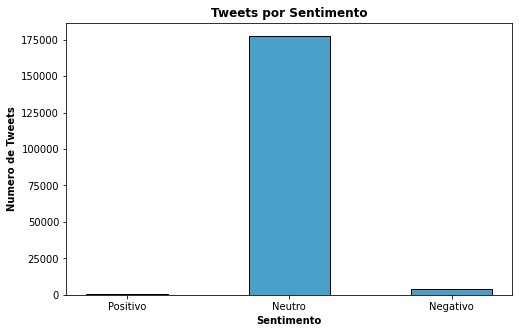

In [110]:
# Graphing the number of  tweets by sentiment
data_t = {'Positivo':positive,'Neutro':neutral,'Negativo':negative}
sentiment_t = data_t.keys()
num_tweets_t = data_t.values() 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='#48A0C9', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentimento", fontweight ='bold') 
plt.ylabel("Numero de Tweets", fontweight ='bold') 
plt.title("Tweets por Sentimento", fontweight ='bold') 
plt.show() 

In [111]:
# Function to return a string of all words in all tweets

def get_all_tweets(df,by_sentiment=False,sentiment="positivo"):
    
    # Combine all words in tweets into a string
    if by_sentiment:
        if sentiment == "positivo":
            words = ' '.join((df.loc[df['predict']=='positivo'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
        elif sentiment == "neutro":
            words = ' '.join((df.loc[df['predict']=='neutro'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
        else:
            words = ' '.join((df.loc[df['predict']=='negativo'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
    else:
        words = ' '.join(df['Tweet_Text'].apply(lambda x: ' '.join(x)))
        
    return words

In [112]:
# Create word strings
words = get_all_tweets(df_b)
words_pos = get_all_tweets(df_b,True,"positivo")
words_neu = get_all_tweets(df_b,True,"neutro")
words_neg= get_all_tweets(df_b,True,"negativo")



In [113]:
#funcao retorna tokens palavras
def stringToList(string):
    listRes = list(string.split(" "))
    return listRes

In [114]:
tokens = stringToList(words)
tokens_pos = stringToList(words_pos)
tokens_neu = stringToList(words_neu)
tokens_neg = stringToList(words_neg)    

In [115]:
print(pd.DataFrame(FreqDist(tokens_pos).most_common(11), columns = ["Palavra","Frequência"]))

      Palavra  Frequência
0     eleição         756
1      brasil         330
2       junto         241
3    esquerda         177
4    política         171
5       nunca         171
6    apoiador         168
7    eliminar         167
8       praga         167
9      chamar         167
10  discórdia         167


In [116]:
# Function to plot most frquent words
def plot_word_freq(tokens,sentiment,name,color):
    fdist = FreqDist(tokens)
    fdist_df = pd.DataFrame(fdist.most_common(10), columns = ["Palavra","Frequência"])
    fig = px.bar(fdist_df, x="Palavra", y="Frequência",
                 title="<b>Palavras mais frequentes em </b>" + "<b>Tweets</b>" + " " + sentiment + " " + name )
    fig.update_traces(marker=dict(color=color),selector=dict(type="bar"),
                      marker_line_color='black', marker_line_width=1.5, opacity=0.6)
    fig.show()


In [117]:
plot_word_freq(tokens,"<b>Total</b>","<b>Tweets</b>","red")

In [118]:
plot_word_freq(tokens_pos,"<b>Positivos</b>","<b></b>","red")

In [119]:
plot_word_freq(tokens_neg,"<b>Negativos</b>","<b></b>","red")

In [120]:
plot_word_freq(tokens_neu,"<b>Neutros</b>","<b></b>","red")

In [121]:
# Function to generate word cloud
def create_wordcloud(words):
    
    # create wordcloud
    wordcloud = WordCloud(max_font_size=256, max_words=200, 
                          background_color="white",
                          collocations=False, 
                          width=2000, height=1000).generate(words)

    # display the generated image
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

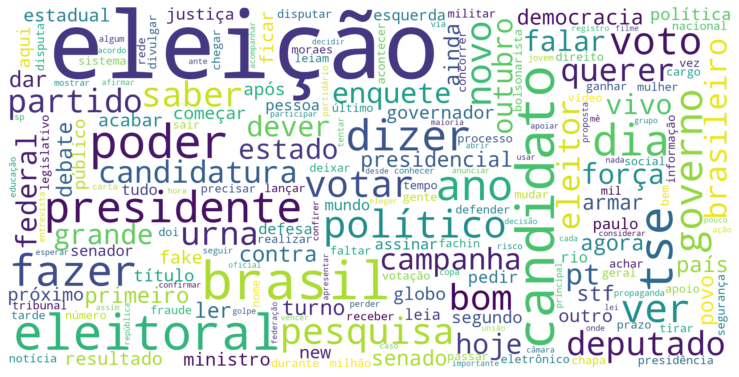

In [122]:
create_wordcloud(words)

In [123]:
#values= df_b.groupby(['User_city', 'predict'])['predict'].count()

In [124]:
#Separar valores data

def encode_dates(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df


In [125]:
df_b= encode_dates(df_b, column='Date_Created')

In [126]:
df_b['User_state']= df_b['User_Location'].str.split(',',n=1, expand=True)[1]

In [127]:
df_b['User_city']= df_b['User_Location'].str.split(',',n=1, expand=True)[0]

In [128]:
df_b.head()

Tweet_ID                                         Tweet_Text  \
3   1569536492938350592  [candidatura, indeferido, gabriel, monteiro, a...   
5   1569536352118460416     [eleição, ver, presidenciável, jornaldarecord]   
9   1569535834680094731  [arma, dizer, bolsonarista, ameaçar, governado...   
10  1569534989565304832                                                 []   
17  1569534318061518849  [jornalista, publicar, coluna, falar, perspect...   

                  Created_at Tweet_Geo         User_Name User_Location  \
3  2022-09-13 01:00:35-03:00       NaN      Jornal Extra        Brasil   
5  2022-09-13 01:00:01-03:00       NaN  Jornal da Record           NaN   
9  2022-09-13 00:57:58-03:00       NaN     LinhadNoticia           NaN   
10 2022-09-13 00:54:36-03:00       NaN             Xeulê           NaN   
17 2022-09-13 00:51:56-03:00       NaN      Jason Bourne           NaN   

                                           Text_Final Time_Created predict  \
3   ['candidatura', 'indeferido', 'gabriel', 'mont...     01:00:35  neutro   
5   ['eleição', 'ver', 'presidenciável', 'jornalda...     01:00:01  neutro   
9   ['arma', 'dizer', 'bolsonarista', 'ameaçar', '...     00:57:58  neutro   
10                                                 []     00:54:36  neutro   
17  ['jornalista', 'publicar', 'coluna', 'falar', ...     00:51:56  neutro   

    Date_Created_year  Date_Created_month  Date_Created_day User_state  \
3                2022                   9                13       None   
5                2022                   9                13        NaN   
9                2022                   9                13        NaN   
10               2022                   9                13        NaN   
17               2022                   9                13        NaN   

   User_city  
3     Brasil  
5        NaN  
9        NaN  
10       NaN  
17       NaN

In [129]:
Tweets_d= df_b.groupby([df_b['Created_at'].dt.strftime('%m-%d'), 'predict'])['Tweet_ID'].count().reset_index()

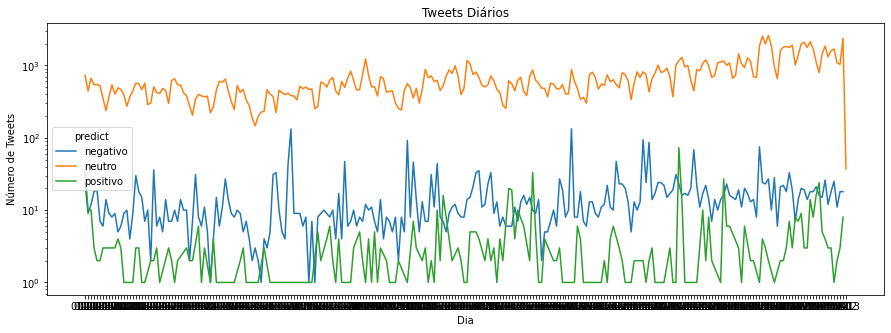

In [130]:
plt.figure(figsize=(15,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', hue='predict', data = Tweets_d)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários')
plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()


In [131]:
Tweets_d.to_csv("eleicoes-data.csv")

In [132]:
tweets_q = df_b.groupby(df_b['Created_at'].dt.strftime('%m-%d'))['Tweet_ID'].count().reset_index()

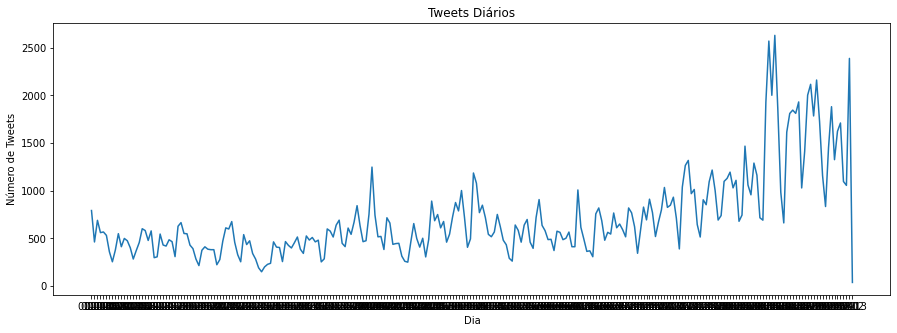

In [133]:
plt.figure(figsize=(15,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', data = tweets_q)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários')
#plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()

In [68]:
tweets_q.to_csv ("tweetsdiarios.csv")

In [134]:
tweets_q

Created_at  Tweet_ID
0        01-01       792
1        01-02       462
2        01-03       689
3        01-04       560
4        01-05       567
..         ...       ...
251      09-09      1711
252      09-10      1097
253      09-11      1056
254      09-12      2389
255      09-13        37

[256 rows x 2 columns]